# Dense And Sparse Correspondence
In this tutorial we show how DINOv3 features can be used to establish correspondences between two objects.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [1]:
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!git clone https://github.com/facebookresearch/dinov3.git
!pip install -e ARGO_Vision_CODEMOTION_2025
!pip install -e dinov3

Cloning into 'ARGO_Vision_CODEMOTION_2025'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 296 (delta 57), reused 26 (delta 13), pack-reused 192 (from 1)
Receiving objects: 100% (296/296), 51.20 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Cloning into 'dinov3'...
remote: Enumerating objects: 446, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 446 (delta 133), reused 95 (delta 69), pack-reused 210 (from 2)
Receiving objects: 100% (446/446), 9.87 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")

In [3]:
import pickle
import os
import urllib

import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
import timm
from codemotion2025.utils.dinov3_utils import last_layer_patch_features_v3

### Model Loading
We load the DINOv3 ViT-L model. Feel free to try other DINOv3 models as well!

In [4]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = ""
MODEL_DINOV3_VITSP = "vit_small_plus_patch16_dinov3_qkvb.lvd1689m"
MODEL_DINOV3_VITB = ""
MODEL_DINOV3_VITL = ""
MODEL_DINOV3_VITHP = ""
MODEL_DINOV3_VIT7B = ""

MODEL_NAME = MODEL_DINOV3_VITSP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(MODEL_NAME, pretrained=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

### Data Loading
Now that we have the model set up, let's load the data. It consists of two image / mask pairs:


In [5]:
image_left_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_left.jpg"
mask_left_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_left_fg.png"
image_right_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_right.jpg"
mask_right_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_right_fg.png"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f)


image_left = load_image_from_url(image_left_uri)
mask_left = load_image_from_url(mask_left_uri)

image_right = load_image_from_url(image_right_uri)
mask_right = load_image_from_url(mask_right_uri)

Let's visualize the two images and the corresponding masks:

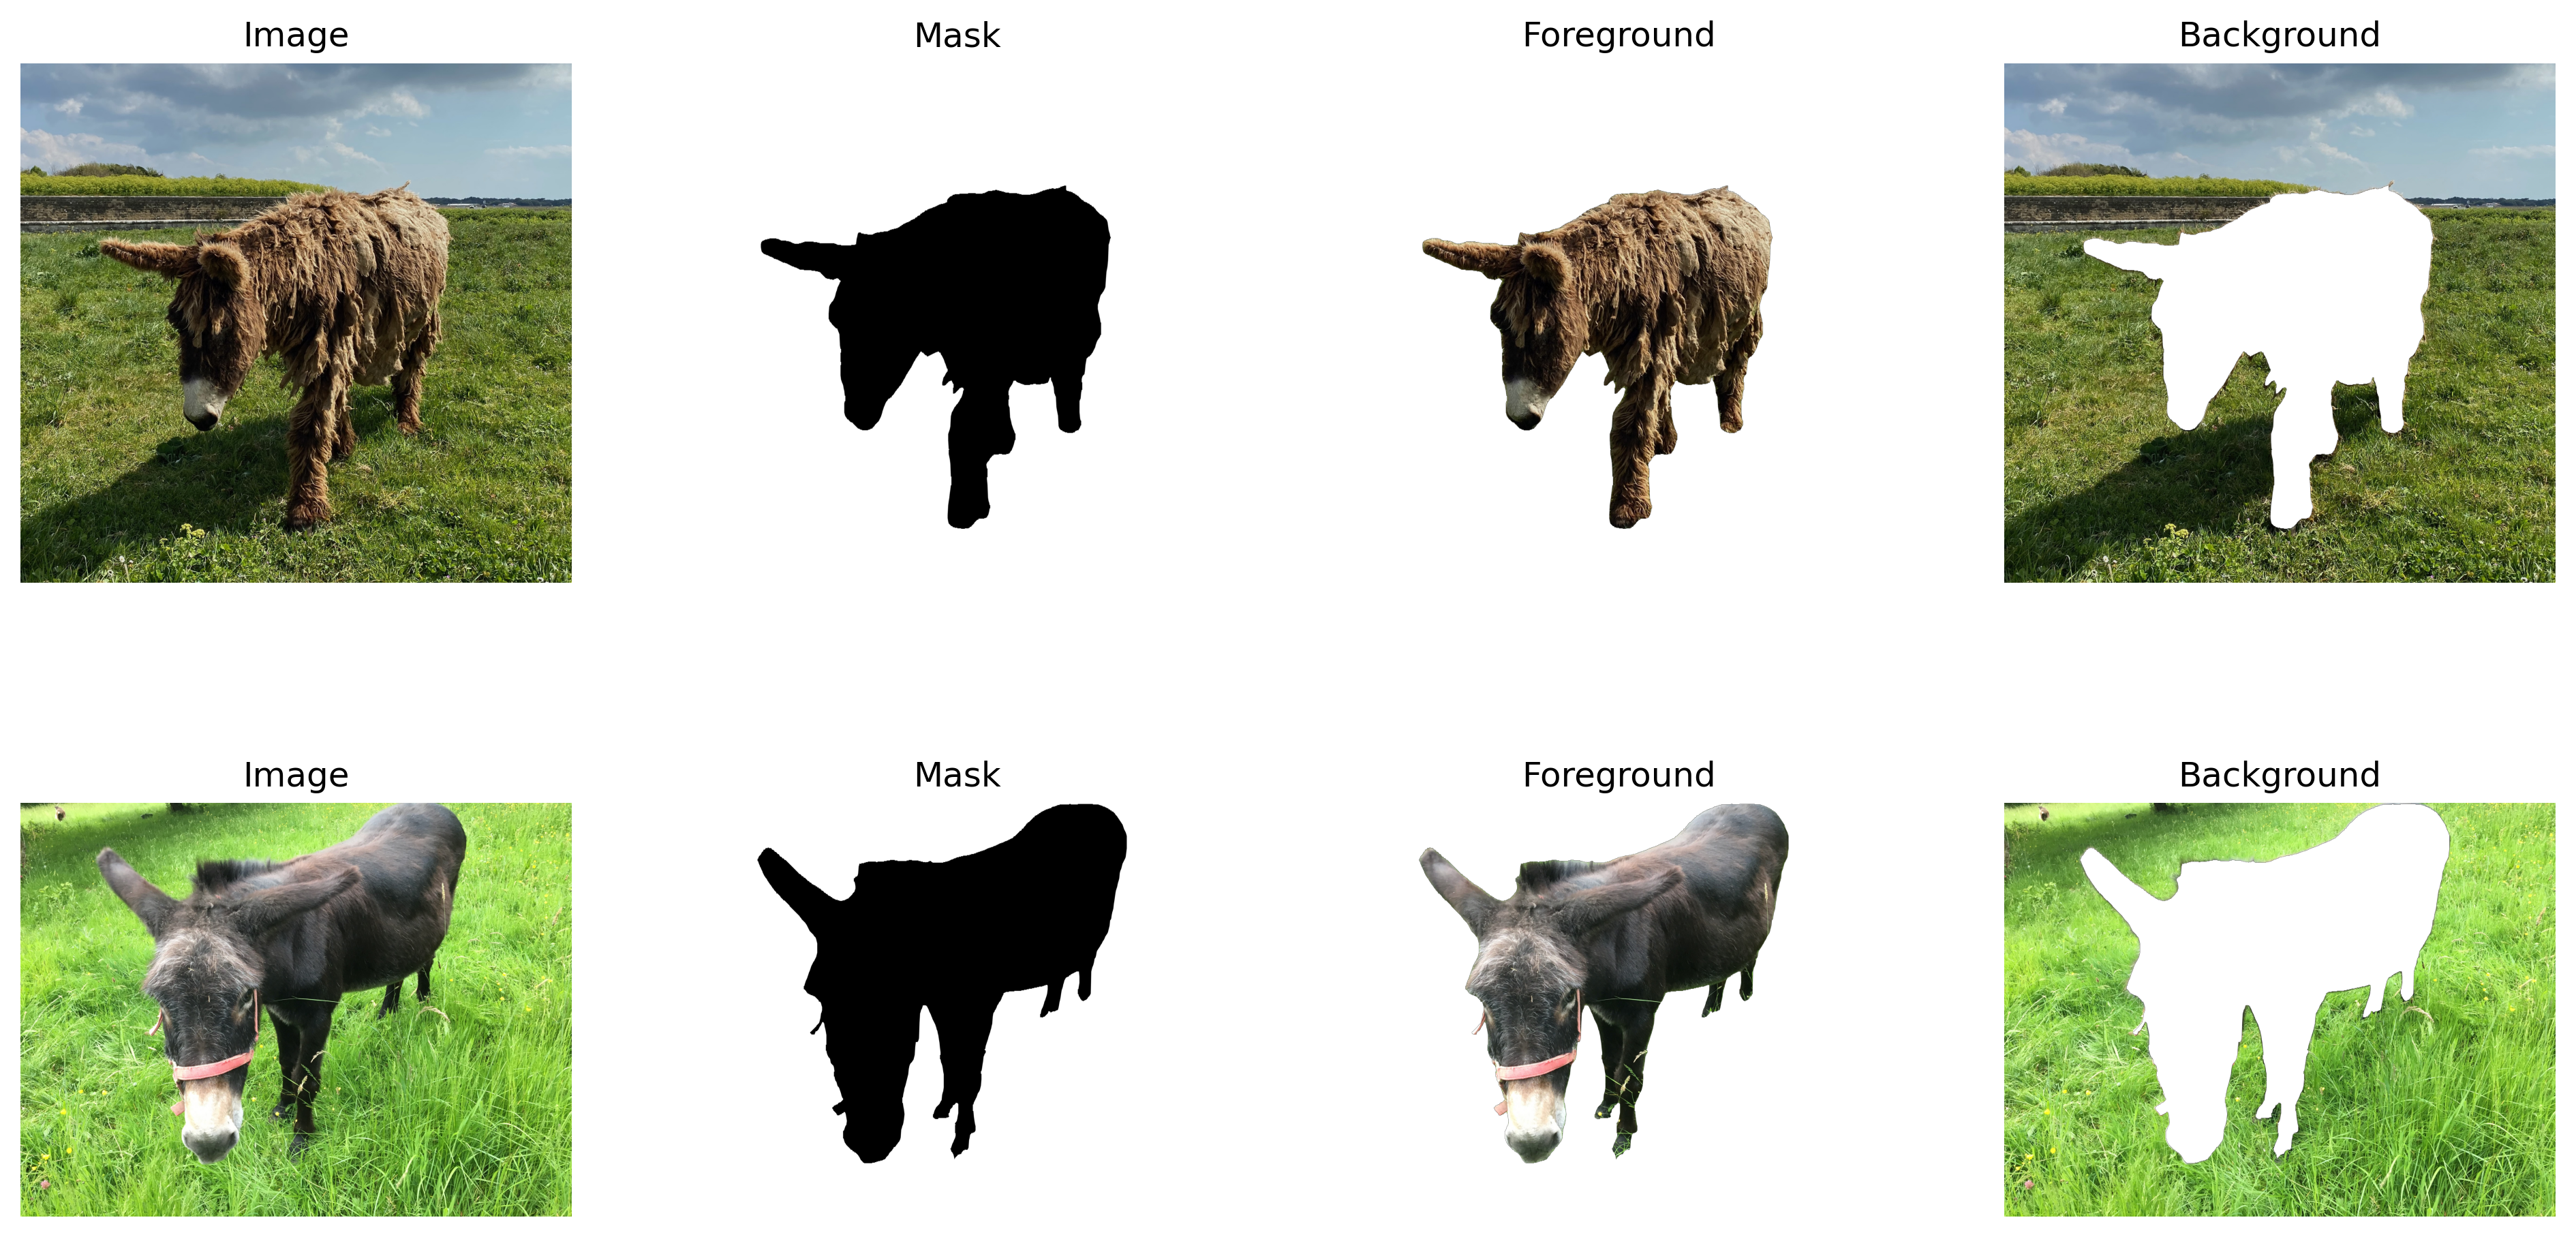

In [6]:
plt.figure(figsize=(16, 8), dpi=300)

for j, (image, mask) in enumerate([(image_left, mask_left), (image_right, mask_right)]):
    foreground = Image.composite(image, mask, mask)
    mask_bg_np = np.copy(np.array(mask))
    mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
    mask_bg = Image.fromarray(mask_bg_np)
    background = Image.composite(image, mask_bg, mask_bg)

    data_to_show = [image, mask, foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]


    for i in range(len(data_to_show)):
        plt.subplot(2, len(data_to_show), 4 * j + i + 1)
        plt.imshow(data_to_show[i])
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)

plt.show()

### Data Transforms

Since our models run with a patch size of 16, we have to quantize the masks to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

In [7]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

### Extracting Features
Now we will extract for each of the two images mask values, as well as the patch features. That involves running the dense feature extraction with our model using the following code snippet :

```
with torch.inference_mode():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    patch_features.append(feats[-1].squeeze().detach().cpu())
```
Each tensor of patch features thus has shape `[D, H, W]`, where `D` is feature dimensionality, and `H` and `W` are image dimensions in the number of patches.

In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

patch_mask_values = []
patch_features = []

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image, mask in tqdm([(image_left, mask_left), (image_right, mask_right)], desc="Processing images"):
            # processing mask
            mask = mask.split()[-1]
            mask_resized = resize_transform(mask)
            #mask_quantized = patch_quant_filter(mask_resized).squeeze().view(-1).detach().cpu()
            mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
            patch_mask_values.append(mask_quantized)
            # processing image
            image = image.convert('RGB')
            image_resized = resize_transform(image)
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_resized = image_resized.unsqueeze(0).to(device)

            feats = last_layer_patch_features_v3(
                model=model,
                x_bchw = image_resized,
                verbose=True
            )

            dim = feats[-1].shape[0]
            patch_features.append(feats[-1].squeeze().detach().cpu())

Processing images:  50%|█████     | 1/2 [00:08<00:08,  8.89s/it]

[last_layer_patch_features_v3]
  input: (1, 3, 768, 800)  patch=16  grid=48x50 (=2400)
  tokens: total=2405, prefix=5, kept=2400
  fmap: (1, 384, 48, 50)  (B,C,Hp,Wp)


Processing images: 100%|██████████| 2/2 [00:17<00:00,  8.71s/it]

[last_layer_patch_features_v3]
  input: (1, 3, 768, 1024)  patch=16  grid=48x64 (=3072)
  tokens: total=3077, prefix=5, kept=3072
  fmap: (1, 384, 48, 64)  (B,C,Hp,Wp)


### Matching Patches

For each patch within the foreground object in the left image, we search for the closest patch in the right image using [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between patch features. We select correspondences only for foreground objects.

In [10]:
MASK_FG_THRESHOLD = 0.5

patch_features[0] = F.normalize(patch_features[0], p=2, dim=0)
patch_features[1] = F.normalize(patch_features[1], p=2, dim=0)


heatmaps = torch.einsum(
    "k f, f h w -> k h w",
    patch_features[0].view(dim, -1).permute(1, 0),
    patch_features[1],
)

# compute 2D patch locations in the left image
n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]
patch_indices_left = torch.arange(n_patches_left)
locs_2d_left = (
    torch.stack(
        (
            patch_indices_left // patch_features[0].shape[2],  # row
            patch_indices_left % patch_features[0].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# compute the corresponding 2D patch locations in the right image
patch_indices_right = torch.flatten(heatmaps, start_dim=-2).argmax(dim=-1)
locs_2d_right = (
    torch.stack(
        (
            patch_indices_right // patch_features[1].shape[2],  # row
            patch_indices_right % patch_features[1].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# foreground patches mask in the left image
patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)
# left image patches mask for patches that map to a foreground patch in the right image
patches_right_fg_selection = (patch_mask_values[1].view(-1)[patch_indices_right] > MASK_FG_THRESHOLD)
# select foreground left image patches that map to foreground right image patches
patches_fg_selection = (patches_left_fg_selection * patches_right_fg_selection)

# select (row, col) coordinates for the matched patches
locs_2d_left_fg = locs_2d_left[patches_fg_selection, :]
locs_2d_right_fg = locs_2d_right[patches_fg_selection, :]

### Dense Correspondence
We now show dense correspondences between patches using the color space estimated through PCA over foreground patches in the left image. Closer colors correspond to more similar patches.

In [11]:
pca = PCA(n_components=3, whiten=True)
fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_fg_selection]
pca.fit(fg_patches_left)

PCA(n_components=3, whiten=True)

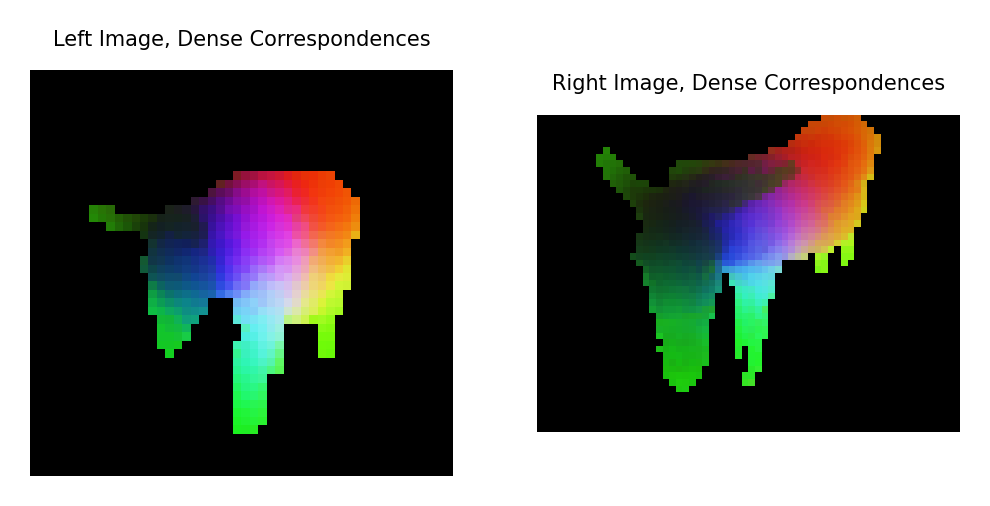

In [12]:
# get colors for the left image
h_patches_left = patch_features[0].shape[1]
w_patches_left = patch_features[0].shape[2]
x_left = patch_features[0].view(dim, -1).permute(1, 0)
projected_image_left = torch.from_numpy(
    pca.transform(x_left.numpy())
).view(h_patches_left, w_patches_left, 3)
# multiply by 2.0 and pass through a sigmoid to get vibrant colors
projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)

# get colors for the right image
h_patches_right = patch_features[1].shape[1]
w_patches_right = patch_features[1].shape[2]
x_right = patch_features[1].view(dim, -1).permute(1, 0)
projected_image_right = torch.from_numpy(
    pca.transform(x_right.numpy())
).view(h_patches_right, w_patches_right, 3)
projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)

# apply foreground masks to both visualizations
projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD)[None, :, :]
projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD)[None, :, :]

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(projected_image_left.permute(1, 2, 0))
plt.title("Left Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(projected_image_right.permute(1, 2, 0))
plt.title("Right Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.show()

### Sparse Correspondence

Finally, we show the established correspondences via the sparse set of matched points.

Non-stratified points: (473, 2)
Stratified points: (54, 2)


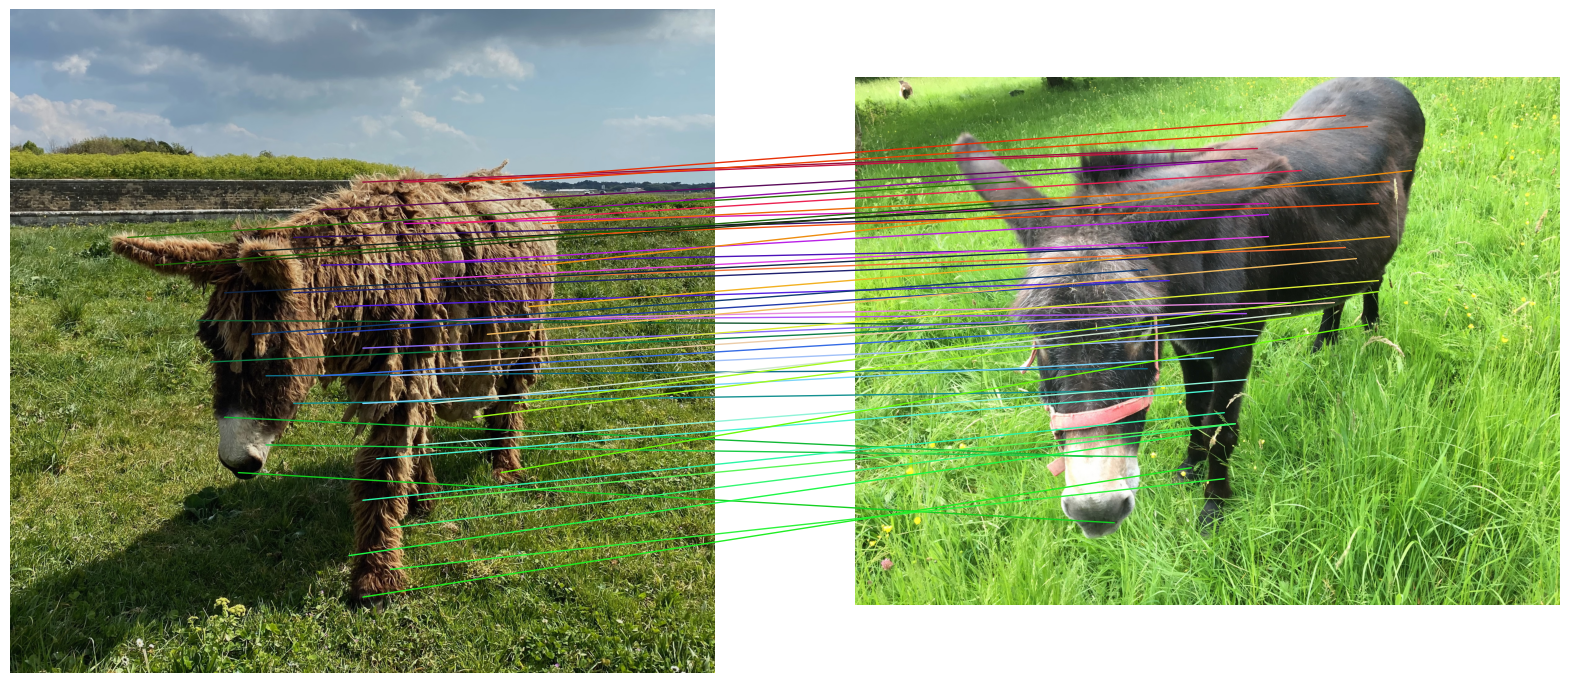

In [13]:
# image scale to go from patches to the original image coordinates
scale_left = image_left.height / IMAGE_SIZE
scale_right = image_right.height / IMAGE_SIZE


STRATIFY_DISTANCE_THRESHOLD = 100.0

def compute_distances_l2(X, Y, X_squared_norm, Y_squared_norm):
    distances = -2 * X @ Y.T
    distances.add_(X_squared_norm[:, None]).add_(Y_squared_norm[None, :])
    return distances


def stratify_points(pts_2d: torch.Tensor, threshold: float = 100.0) -> torch.Tensor:
    # pts_2d: [N, 2]
    n = len(pts_2d)
    max_value = threshold + 1
    pts_2d_sq_norms = torch.linalg.vector_norm(pts_2d, dim=1)
    pts_2d_sq_norms.square_()
    distances = compute_distances_l2(pts_2d, pts_2d, pts_2d_sq_norms, pts_2d_sq_norms)
    distances.fill_diagonal_(max_value)
    distances_mask = torch.empty((n, n), dtype=pts_2d.dtype, device=pts_2d.device)
    torch.le(distances, threshold, out=distances_mask)
    ones_vec = torch.ones(n, device=pts_2d.device, dtype=pts_2d.dtype)
    counts_vec = torch.mv(distances_mask, ones_vec)
    indices_mask = np.ones(n)
    while torch.any(counts_vec).item():
        index_max = torch.argmax(counts_vec).item()
        indices_mask[index_max] = 0
        distances[index_max, :] = max_value
        distances[:, index_max] = max_value
        torch.le(distances, threshold, out=distances_mask)
        torch.mv(distances_mask, ones_vec, out=counts_vec)
    indices_to_exclude = np.nonzero(indices_mask == 0)[0]
    indices_to_keep = np.nonzero(indices_mask > 0)[0]
    return indices_to_exclude, indices_to_keep

print(f"Non-stratified points: {tuple(locs_2d_left_fg.shape)}")

indices_to_exclude, indices_to_keep = stratify_points(locs_2d_left_fg * scale_left, STRATIFY_DISTANCE_THRESHOLD**2)

sparse_points_left_yx = locs_2d_left_fg[indices_to_keep, :].cpu().numpy()
sparse_points_right_yx = locs_2d_right_fg[indices_to_keep, :].cpu().numpy()

print(f"Stratified points: {sparse_points_left_yx.shape}")

# show original left and right images
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(image_left)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
ax2.imshow(image_right)
ax2.set_axis_off()


for i, (row_left, col_left), (row_right, col_right) in zip(
    indices_to_keep, sparse_points_left_yx, sparse_points_right_yx
):
    row_left_orig, col_left_orig = locs_2d_left_fg[i]
    # use the color used for PCA visualization
    color = projected_image_left[
        :,
        int(row_left_orig / PATCH_SIZE),
        int(col_left_orig / PATCH_SIZE)
    ].cpu().numpy()
    con = ConnectionPatch(
        xyA=(col_left * scale_left, row_left * scale_left),
        xyB=(col_right * scale_right, row_right * scale_right),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        color=color,
    )
    ax2.add_artist(con)